## Informação sobre o Dataset

Nós trabalhamos como cientista de dados em uma empresa financeira global. Ao longo dos anos, a empresa coletou detalhes bancários básicos e reuniu muitas informações relacionadas a crédito. A gestão quer construir um sistema inteligente para separar as pessoas em faixas de pontuação de crédito, para reduzir os esforços manuais.

Para isso, temos as seguintes informações:

* **ID**: Representa uma identificação única de uma entrada.
* **Customer_ID**: Representa uma identificação única de uma pessoa.
* **Month**: Representa o mês do ano.
* **Name**: Representa o nome de uma pessoa.
* **Age**: Representa a idade da pessoa.
* **SSN**: Representa o número de Seguro Social de uma pessoa.
* **Occupation**: Representa a ocupação da pessoa.
* **Annual_Income**: Representa a renda anual da pessoa.
* **Monthly_Inhand_Salary**: Representa o salário mensal líquido de uma pessoa.
* **Num_Bank_Accounts**: Representa o número de contas bancárias que uma pessoa possui.
* **Num_Credit_Card**: Representa o número de outros cartões de crédito detidos por uma pessoa.
* **Interest_Rate**: Representa a taxa de juros no cartão de crédito.
* **Num_of_Loan**: Representa o número de empréstimos concedidos pelo banco.
* **Type_of_Loan**: Representa os tipos de empréstimo concedidos a uma pessoa.
* **Delay_from_due_date**: Representa o número médio de dias de atraso a partir da data de vencimento.
* **Num_of_Delayed_Payment**: Representa o número médio de pagamentos atrasados por uma pessoa.
* **Changed_Credit_Limit**: Representa a alteração percentual no limite do cartão de crédito.
* **Num_Credit_Inquiries**: Representa o número de consultas de crédito.
* **Credit_Mix**: Representa a classificação da mistura de créditos.
* **Outstanding_Debt**: Representa a dívida pendente a ser paga (em USD).
* **Credit_Utilization_Ratio**: Representa a taxa de utilização do cartão de crédito.
* **Credit_History_Age**: Representa a idade do histórico de crédito da pessoa.
* **Payment_of_Min_Amount**: Representa se apenas o valor mínimo foi pago pela pessoa.
* **Total_EMI_per_month**: Representa os pagamentos mensais de EMI (em USD).
* **Amount_invested_monthly**: Representa o valor investido mensalmente pelo cliente (em USD).
* **Payment_Behaviour**: Representa o comportamento de pagamento do cliente (em USD).
* **Monthly_Balance**: Representa o saldo mensal do cliente (em USD).
* **Credit_Score**: Representa o intervalo de pontuação de crédito (Pobre, Padrão, Bom).

## Importação das bibliotecas e do dataframe

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install category_encoders
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
import re
import pickle
from matplotlib.ticker import FixedLocator
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc, roc_auc_score, confusion_matrix
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from math import floor
from scipy.stats import f_oneway
from scipy.stats import mode
from scipy import stats
from category_encoders import CatBoostEncoder
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('/content/drive/MyDrive/train.csv', low_memory=False)

## Funções que serão utilizadas

In [5]:
# Função para remover algumas sujeiras no dataset, algumas linhas possuem '_' como erro e isso será tratado
def remover_(df, colunas):
    for coluna in colunas:
      df[coluna] = df[coluna].str.replace('_', '')
    return df


In [6]:
# Função para ajustar idade que foi preenchida incorretamente
def ajustar_idade(grupo):
    moda = grupo['Age'].mode().iloc[0]
    min_value = grupo['Age'].min()
    max_value = grupo['Age'].max()

    if pd.isna(min_value) or pd.isna(max_value):
        grupo['Age'] = grupo['Age'].fillna(moda)
    elif moda - min_value > 1:
        grupo['Age'] = moda
    elif max_value - moda > 1:
        grupo['Age'] = moda

    return grupo

In [7]:
# Função para substituir valores negativos que foram preenchidos incorretamente
def substitui_negativo(df, columns):
    for col in columns:
        if col in df.columns:
            # Calcula a moda para cada Customer_ID para valores não-negativos
            moda_por_cliente = df[df[col] >= 0].groupby('Customer_ID')[col].agg(lambda x: mode(x)[0] if len(x) > 0 else 0)
            # Substitui valores negativos pela moda correspondente
            for customer_id in moda_por_cliente.index:
                moda = moda_por_cliente[customer_id]
                df.loc[(df['Customer_ID'] == customer_id) & (df[col] < 0), col] = moda
    return df

In [8]:
# Função para transformar a coluna no formato 'X anos e Y meses' para total de meses
def extrair_total_meses(string):
    padrao_anos = r'(\d+) Years'
    padrao_meses = r'(\d+) Months'
    match_anos = re.search(padrao_anos, str(string))
    match_meses = re.search(padrao_meses, str(string))

    total_meses = 0

    if match_anos:
        anos = int(match_anos.group(1))
        total_meses += anos * 12


    if match_meses:
        meses = int(match_meses.group(1))
        total_meses += meses

    return total_meses


## Explorando o Dataset

In [9]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [10]:
df.shape

(100000, 28)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [12]:
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


## Limpeza dos dados

In [13]:
colunas_com_underline = df.applymap(lambda x: '_' in str(x)).any()
colunas_com_underline = colunas_com_underline[colunas_com_underline].index.tolist()
colunas_com_underline

['Customer_ID',
 'Age',
 'Occupation',
 'Annual_Income',
 'Num_of_Loan',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Credit_Mix',
 'Outstanding_Debt',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance']

In [14]:
for coluna in colunas_com_underline:
    print("Coluna:", coluna)
    strings_com_underline = df[coluna].fillna('').loc[df[coluna].str.contains('_').fillna(False)].head()
    print(strings_com_underline)
    print()

Coluna: Customer_ID
0    CUS_0xd40
1    CUS_0xd40
2    CUS_0xd40
3    CUS_0xd40
4    CUS_0xd40
Name: Customer_ID, dtype: object

Coluna: Age
8     28_
54    34_
58    30_
71    24_
89    33_
Name: Age, dtype: object

Coluna: Occupation
8     _______
16    _______
18    _______
20    _______
29    _______
Name: Occupation, dtype: object

Coluna: Annual_Income
10     34847.84_
27     30689.89_
32     35547.71_
56     34081.38_
66    114838.41_
Name: Annual_Income, dtype: object

Coluna: Num_of_Loan
37     0_
80     3_
84     3_
94     2_
119    5_
Name: Num_of_Loan, dtype: object

Coluna: Num_of_Delayed_Payment
6       8_
11      3_
53      3_
54      2_
119    13_
Name: Num_of_Delayed_Payment, dtype: object

Coluna: Changed_Credit_Limit
2      _
65     _
66     _
109    _
110    _
Name: Changed_Credit_Limit, dtype: object

Coluna: Credit_Mix
0     _
10    _
19    _
29    _
35    _
Name: Credit_Mix, dtype: object

Coluna: Outstanding_Debt
87     1328.93_
142    1283.37_
368    2797.17_
6

In [15]:
colunas_com_underline.remove('Customer_ID')
colunas_com_underline.remove('Payment_Behaviour')

In [16]:
df = remover_(df,colunas_com_underline)

Existem várias colunas que estão com tipo errado, vamos ajustar

In [17]:
df['Age'] = df['Age'].astype(int)
df['Annual_Income'] = df['Annual_Income'].astype(float)
df['Num_of_Loan'] = df['Num_of_Loan'].astype(int)
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'], errors='coerce')
df['Changed_Credit_Limit'] = pd.to_numeric(df['Changed_Credit_Limit'], errors='coerce')
df['Outstanding_Debt'] = pd.to_numeric(df['Outstanding_Debt'], errors='coerce')
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'], errors='coerce')
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce')

Existem vários erros de preenchimento e muitas colunas com valores negativos que não deveriam existir, como podemos ter vários registros de uma mesma pessoa, vamos tentar corrigir esses erros

In [18]:
df = df.groupby('Customer_ID', group_keys=False).apply(ajustar_idade)

In [19]:
for col in df.select_dtypes(include=['number']).columns:
  qtd_negativos = (df[col] < 0).sum()
  if qtd_negativos > 0:
    print(col)
    print(qtd_negativos)

Num_Bank_Accounts
21
Num_of_Loan
3876
Delay_from_due_date
591
Num_of_Delayed_Payment
644
Changed_Credit_Limit
1586
Monthly_Balance
9


Analisando as colunas com valores negativos, número de contas, número de empréstimos e número de pagamentos atrasados não podem ser negativas, as outras como não temos informações, a princípio iremos manter esses valores

In [20]:
cols_negativas = ['Num_Bank_Accounts','Num_of_Loan','Num_of_Delayed_Payment']

In [21]:
df = substitui_negativo(df,cols_negativas)

## Feature engineering

Iremos abrir a coluna 'Type of Loan' para criar colunas binárias informando sobre cada tipo de empréstimo obtido

In [22]:
df['Type_of_Loan'] = df['Type_of_Loan'].fillna('')

In [23]:
all_types = set()
for items in df['Type_of_Loan']:
    # Remove ', and ' diretamente para evitar adicionar uma vírgula extra
    items_clean = items.replace(', and ', ', ').replace(', and', ',')
    # Normaliza as sequências de separação para uma única vírgula
    items_clean = re.sub(r',\s+', ',', items_clean)
    for item in items_clean.split(','):
        # Adiciona cada tipo de empréstimo único ao conjunto, removendo espaços em branco extras
        all_types.add(item.strip())

# Adiciona as colunas ao df_final para cada tipo de empréstimo encontrado
for loan_type in all_types:
    df[loan_type] = 0

# Atualiza o df_final para marcar a presença de cada tipo de empréstimo
for index, row in df.iterrows():
    # Limpa a string de novo para remover ', and ' antes de dividir
    items_clean = row['Type_of_Loan'].replace(', and ', ', ').replace(', and', ',')
    # Normaliza as sequências de separação
    items_clean = re.sub(r',\s+', ',', items_clean)
    if items_clean:
        for loan_type in all_types:
            if loan_type in items_clean.split(','):
                df.at[index, loan_type] = 1

Também iremos criar uma nova coluna com o total de meses de histórico de crédito que o cliente tem

In [24]:
df['Credit_History_Months'] = df['Credit_History_Age'].apply(extrair_total_meses)

Nesse momento, iremos assumir que apenas pretendemos diferenciar os bons e maus pagadores, portanto iremos transformar as pontuações de padrão e boa em apenas boa

In [25]:
scores = {
    'Poor': 0,
    'Standard': 1,
    'Good': 1
}

df['Credit_Score'] = df['Credit_Score'].replace(scores)

In [26]:
df['Income_Accounts'] = np.where(df['Num_Bank_Accounts'] == 0, 0, df['Annual_Income'] / df['Num_Bank_Accounts'])
df['Income_CC'] = np.where(df['Num_Credit_Card'] == 0, 0, df['Annual_Income'] / df['Num_Credit_Card'])
df['Income_Loan'] = np.where(df['Num_of_Loan'] == 0, 0, df['Annual_Income'] / df['Num_of_Loan'])
df['Salary_Accounts'] = np.where(df['Num_Bank_Accounts'] == 0, 0, df['Monthly_Inhand_Salary'] / df['Num_Bank_Accounts'])
df['Salary_CC'] = np.where(df['Num_Credit_Card'] == 0, 0, df['Monthly_Inhand_Salary'] / df['Num_Credit_Card'])
df['Salary_Loan'] = np.where(df['Num_of_Loan'] == 0, 0, df['Monthly_Inhand_Salary'] / df['Num_of_Loan'])
df['Income_Debt'] = np.where(df['Annual_Income'] == 0, 0, df['Outstanding_Debt'] / df['Annual_Income'])
df['Income_Invested'] = np.where(df['Amount_invested_monthly'] == 0, 0, df['Annual_Income'] / df['Amount_invested_monthly'])
df['Salary_Invested'] = np.where(df['Amount_invested_monthly'] == 0, 0, df['Monthly_Inhand_Salary'] / df['Amount_invested_monthly'])

In [27]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,,Auto Loan,Payday Loan,Personal Loan,Not Specified,Mortgage Loan,Debt Consolidation Loan,Home Equity Loan,Credit-Builder Loan,Student Loan,Credit_History_Months,Income_Accounts,Income_CC,Income_Loan,Salary_Accounts,Salary_CC,Salary_Loan,Income_Debt,Income_Invested,Salary_Invested
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,11.27,4.0,,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,1,0,1,0,1,0,0,0,1,1,0,265,6371.373333,4778.53,4778.53,608.281111,456.210833,456.210833,0.042376,237.692592,22.692739
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,1,0,1,0,1,0,0,0,1,1,0,0,6371.373333,4778.53,4778.53,NaN,NaN,NaN,0.042376,161.600306,NaN
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,NaN,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,1,0,1,0,1,0,0,0,1,1,0,267,6371.373333,4778.53,4778.53,NaN,NaN,NaN,0.042376,233.956328,NaN
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4.0,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,1,0,1,0,1,0,0,0,1,1,0,268,6371.373333,4778.53,4778.53,NaN,NaN,NaN,0.042376,95.830264,NaN
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,1,0,1,0,1,0,0,0,1,1,0,269,6371.373333,4778.53,4778.53,608.281111,456.210833,456.210833,0.042376,461.469081,44.056895


In [28]:
df_final = df.drop(['ID', 'Customer_ID', 'Name', 'SSN', '', 'Credit_History_Age', 'Type_of_Loan'], axis = 1)

In [29]:
df_final.columns

Index(['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Payment_of_Min_Amount',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour',
       'Monthly_Balance', 'Credit_Score', 'Auto Loan', 'Payday Loan',
       'Personal Loan', 'Not Specified', 'Mortgage Loan',
       'Debt Consolidation Loan', 'Home Equity Loan', 'Credit-Builder Loan',
       'Student Loan', 'Credit_History_Months', 'Income_Accounts', 'Income_CC',
       'Income_Loan', 'Salary_Accounts', 'Salary_CC', 'Salary_Loan',
       'Income_Debt', 'Income_Invested', 'Salary_Invested'],
      dtype='object')

In [30]:
df_final.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score,Auto Loan,Payday Loan,Personal Loan,Not Specified,Mortgage Loan,Debt Consolidation Loan,Home Equity Loan,Credit-Builder Loan,Student Loan,Credit_History_Months,Income_Accounts,Income_CC,Income_Loan,Salary_Accounts,Salary_CC,Salary_Loan,Income_Debt,Income_Invested,Salary_Invested
count,100000.000000,1.000000e+05,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,92998.000000,97909.000000,98035.000000,100000.000000,100000.000000,100000.000000,95521.000000,9.880000e+04,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.00000,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,85658.000000,84999.000000,86763.000000,1.000000e+05,9.552100e+04,81265.000000
mean,33.311210,1.764157e+05,4194.170850,17.091490,22.47443,72.466040,7.022880,21.068780,30.939633,10.389025,27.754251,1426.220376,32.285173,1403.118217,637.412998,-3.036437e+22,0.710020,0.305600,0.319440,0.311040,0.316800,0.313600,0.31040,0.314000,0.31728,0.31040,201.221460,4.066304e+04,3.791468e+04,5.938508e+04,1060.145114,974.701954,1447.123499,6.001771e-02,1.745101e+03,29.118906
std,10.764519,1.429618e+06,3183.686167,117.404803,129.05741,466.422621,59.140535,14.860104,226.029629,6.789496,193.177339,1155.129026,5.116875,8306.041270,2043.319327,3.181295e+24,0.453755,0.460663,0.466262,0.462921,0.465231,0.463958,0.46266,0.464119,0.46542,0.46266,114.320699,4.134007e+05,3.441951e+05,6.197624e+05,1627.185957,1242.908141,2073.083231,8.713630e-02,2.302706e+04,24.999914
min,14.000000,7.005930e+03,303.645417,0.000000,0.00000,1.000000,0.000000,-5.000000,0.000000,-6.490000,0.000000,0.230000,20.000000,0.000000,0.000000,-3.333333e+26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,4.086800e-07,0.000000e+00,0.000000
25%,24.000000,1.945750e+04,1625.568229,3.000000,4.00000,8.000000,2.000000,10.000000,9.000000,5.320000,3.000000,566.072500,28.052567,30.306660,74.534002,2.700922e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,114.000000,2.871427e+03,3.453579e+03,3.094547e+03,231.906214,283.773704,233.099444,9.260348e-03,1.504195e+02,12.325276
50%,33.000000,3.757861e+04,3093.745000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.155000,32.305784,69.249473,135.925682,3.367192e+02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,208.000000,6.723563e+03,7.176685e+03,8.942065e+03,544.661786,586.572500,713.373214,2.780103e-02,2.588962e+02,21.057656
75%,42.000000,7.279092e+04,5957.448333,7.000000,7.00000,20.000000,5.000000,28.000000,18.000000,14.870000,9.000000,1945.962500,36.496663,161.224249,265.731733,4.702202e+02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.00000,292.000000,1.494527e+04,1.504827e+04,2.214318e+04,1203.335667,1221.549167,1773.147500,6.908294e-02,4.704631e+02,38.203169
max,56.000000,2.419806e+07,15204.633333,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,82331.000000,10000.000000,1.602041e+03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.00000,404.000000,2.355033e+07,2.270538e+07,2.388456e+07,14929.540000,14813.530000,15091.086667,6.832516e-01,1.503768e+06,154.052225


## Análise dos Dados

In [31]:
analise_cols = []

for column in df_final.columns:
    tipo_variavel = df[column].dtype
    qtd_nulos = df[column].isnull().sum()
    pct_nulos = round((qtd_nulos / len(df)) * 100, 2)
    cardinalidade = df[column].nunique()

    analise_cols.append([column, tipo_variavel, qtd_nulos, pct_nulos, cardinalidade])

summary_df = pd.DataFrame(analise_cols, columns=['Coluna', 'Tipo Variável', 'Valores Nulos', 'Porcentagem de Nulos (%)', 'Valores Únicos'])

summary_df

,Coluna,Tipo Variável,Valores Nulos,Porcentagem de Nulos (%),Valores Únicos
0,Month,object,0,0.00,8
1,Age,int64,0,0.00,43
2,Occupation,object,0,0.00,16
3,Annual_Income,float64,0,0.00,13487
4,Monthly_Inhand_Salary,float64,15002,15.00,13235
5,Num_Bank_Accounts,int64,0,0.00,942
6,Num_Credit_Card,int64,0,0.00,1179
7,Interest_Rate,int64,0,0.00,1750
8,Num_of_Loan,int64,0,0.00,413
9,Delay_from_due_date,int64,0,0.00,73


In [32]:
sns.set_theme(style="darkgrid")

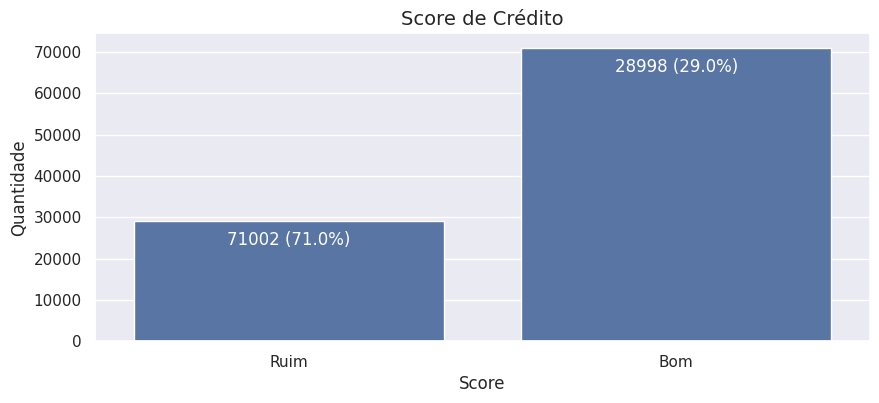

In [33]:
total = len(df_final['Credit_Score'])
counts = df_final['Credit_Score'].value_counts()

plt.figure(figsize=(10,4))
fig = sns.countplot(data = df_final, x='Credit_Score')
fig.set_title('Score de Crédito', fontsize=14)
fig.set_xlabel('Score', fontsize=12)
fig.set_ylabel('Quantidade', fontsize=12)
labels = [f"{v} ({v/total:.1%})" for v in counts]
fig.bar_label(fig.containers[0], labels=labels, padding=-20, color='white', fontsize=12)
fig.xaxis.set_major_locator(FixedLocator([0, 1]))
fig.set_xticklabels(['Ruim', 'Bom'])
plt.show()

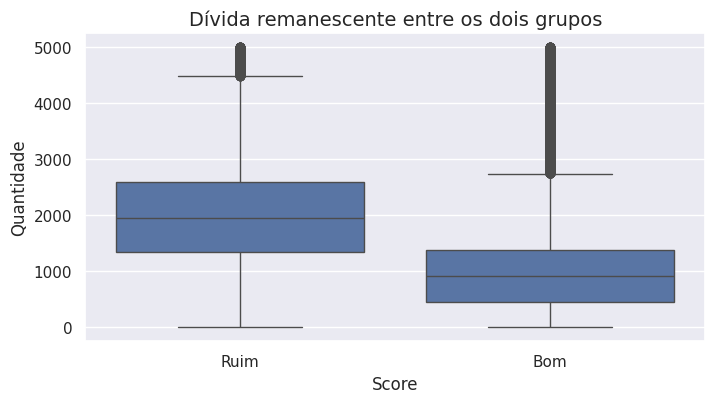

In [34]:
plt.figure(figsize=(8,4))
fig = sns.boxplot(data=df_final, x='Credit_Score', y='Outstanding_Debt')
fig.set_title('Dívida remanescente entre os dois grupos', fontsize=14)
fig.set_xlabel('Score', fontsize=12)
fig.set_ylabel('Quantidade', fontsize=12)
fig.xaxis.set_major_locator(FixedLocator([0, 1]))
fig.set_xticklabels(['Ruim', 'Bom'])
plt.show()

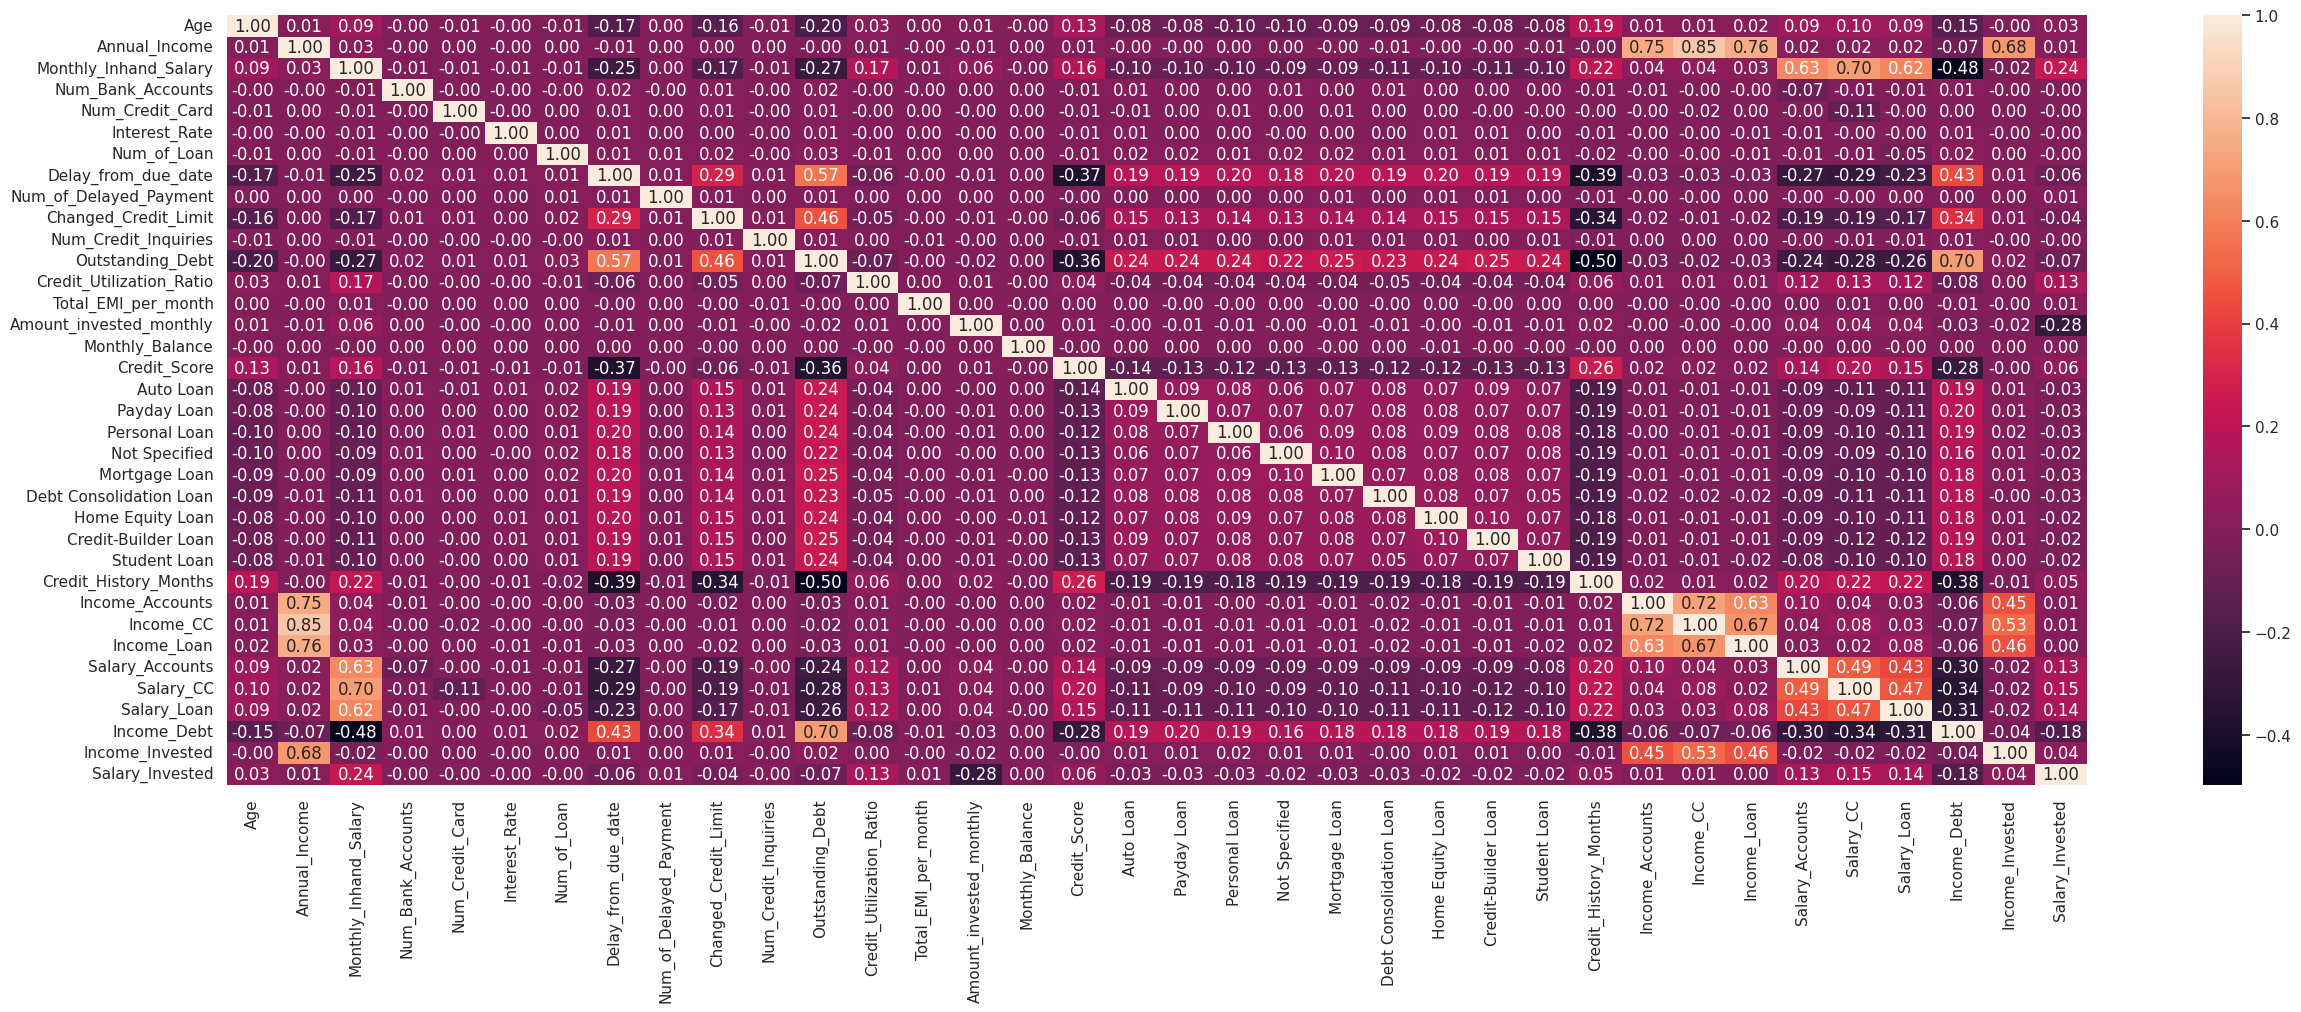

In [35]:
numeric_columns = df_final.select_dtypes(include='number')
fig = sns.heatmap(data=numeric_columns.corr(method='pearson'), annot=True, fmt='.2f', xticklabels=True, yticklabels=True)
fig.figure.set_size_inches(30, 10)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Modelagem de Dados

In [36]:
X = df_final.drop('Credit_Score', axis=1)
y = df_final['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000, 40), (30000, 40), (70000,), (30000,))

In [38]:
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gradient', GradientBoostingClassifier(random_state=42)),
    ('knn', KNeighborsClassifier()),
    ('svc', SVC(random_state=42))
]

In [39]:
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')

cat_pipeline = Pipeline([('imputer', cat_imputer), ('encoder', CatBoostEncoder())])
num_pipeline = Pipeline([('imputer', num_imputer)])

cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])

final_model = LogisticRegression()

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=final_model, cv=5)



model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', stacking_clf)])


model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'O...
                                                  Index(['Month', 'Occupation', 'Credit_Mix', 'Payment_of_Min_Amount',
       'Payment_Behaviour'],
      dtype='object'))])),
                ('classifier',
                 StackingClassifier(cv=5,
                                    estimators=[('rf',
                                                 RandomForestClassifier(random_state=42)),
                                                ('gradient',
                                                 GradientBoostingClassifier(random_state=42)),
                                                ('knn', KNeighborsClassifier()),
                                                ('svc', SVC(random_state=42))],
                                    final_estimator=LogisticRegression()))])

In [63]:
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

conf_matrix = confusion_matrix(y_test, y_pred)


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC", roc_auc)

Precision: 0.9068684516880093
Recall: 0.9142763250551618
F1-score: 0.9105573218627269
ROC-AUC 0.9303965810119116


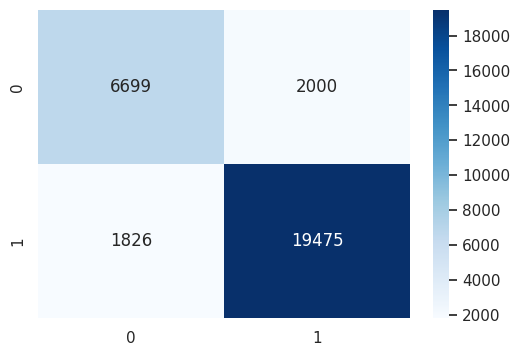

In [41]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

In [42]:
with open('modelo.pkl', 'wb') as file:
    pickle.dump(model_pipeline, file)

## Análise de Negócio

O Modelo atual possui 2000 de falsos positivos, ou seja, aproximadamente 7% da base que o modelo previu que iria pagar e que não vão.

Para tentar fazer com que esses clientes paguem, vamos oferecer um desconto de 10% no valor que falta pagarem do empréstimo.

Vamos supor também, que com esse desconto conseguiremos recuperar 65% dos falsos positivos, sendo que o restante continuará inadimplente.

In [49]:
false_positives = np.logical_and(y_pred == 1, y_test == 0)

false_positives_indices = np.where(false_positives)[0]

falsos_positivos_X_test = X_test.iloc[false_positives_indices]

In [64]:
# Separando uma amostragem aleatória dos 65%
fp_recuperados = falsos_positivos_X_test.sample(int(0.65*len(false_positives_indices)), random_state=0)

# Separando os 45% restantes
indices_restantes_fp = list(set(falsos_positivos_X_test.index) - set(fp_recuperados.index))

fp_nao_recuperados = falsos_positivos_X_test.loc[indices_restantes_fp]

In [65]:
fp_recuperados['Outstanding_Debt_Discount'] = fp_recuperados['Outstanding_Debt'] - (fp_recuperados['Outstanding_Debt'] * 0.1)

round(fp_recuperados['Outstanding_Debt_Discount'].sum(),2)

1667815.47

**Ou seja, o valor recuperado com o desconto de 10% seria:** de **R$ 1.667.815,47**

Porém, também teríamos duas perdas:
1.   Clientes que oferecemos desconto e mesmo assim não pagaram

2. 10% de desconto que daríamos também para os falsos negativos, ou seja, clientes que pagariam e nosso modelo disse que não pagaria

In [66]:
fp_nao_recuperados['Outstanding_Debt'].sum()

1004739.0900000001

Para o primeiro caso, nossa perda seria de: **R$ 1.004.739,09**

In [ ]:
false_negatives = np.logical_and(y_pred == 0, y_test == 1)

false_negatives_indices = np.where(false_negatives)[0]

false_negatives_X_test = X_test.iloc[false_negatives_indices]

false_negatives_X_test['New_Debt'] = false_negatives_X_test['Outstanding_Debt'] * 0.9

false_negatives_X_test['Diff'] = false_negatives_X_test['Outstanding_Debt'] - false_negatives_X_test['New_Debt']

In [68]:
round(false_negatives_X_test['Diff'].sum(),2)

422324.26

Para o segundo caso, nossa perda seria de: **R$ 422.324,26**

**Resultado**

Como vimos, ganharíamos um total de **R$ 1.667.815,47** com o desconto aplicado as dívidas dos clientes.


Porém, iríamos perder **1.427.063.29** (1.004.739,09 + 422.324,2 ) com os outros erros do nosso modelo.

Mas ainda assim, teríamos um lucro de **R$ 240.752,18**

Portanto, mesmo com os gastos de implementação, ainda teríamos um bom lucro.

Isso sem contar com a redução da diminuição dos inadimplentes que temos hoje em dia.